# **A/B-тестирование в ритейле: демонстрация навыков и анализа**  

Этот проект создан для демонстрации моих знаний и навыков в области A/B-тестирования. В процессе работы используются различные методы статистического анализа и оптимизации, чтобы показать их эффективность и применимость в реальных бизнес-задачах.  

## **Описание проекта**  
В данном ноутбуке последовательно рассматриваются:  
1. Основы A/B-тестирования и проверка гипотез с использованием классических подходов.  
2. Методы повышения чувствительности тестов, включая CUPED.  
3. Техника линеаризации для работы с ratio-метриками.  
4. Подходы к множественному тестированию.  
5. Байесовский анализ для гибкости и информативности выводов.  

Каждый из разделов сопровождается теоретическим объяснением, практической реализацией на Python и интерпретацией результатов.  

## **Описание данных**  
В проекте используется датасет с ритейл-данными, содержащий информацию о покупках за три месяца.  
- **Структура данных:** Каждый покупатель представлен своими уникальными идентификаторами, а покупки включают такие параметры, как сумма, дата, и категория товара.  
- **Применение:** Данные позволяют анализировать поведение клиентов, оценивать влияние изменений на ключевые метрики, такие как средний чек (AOV), частота покупок и конверсия.  

Ссылка на данные: *https://www.kaggle.com/datasets/mvyurchenko/x5-retail-hero/data*  

Данные были предобработаны в рамках другого проекта, посвященного дата-аналитике в ритейле.

Этот проект направлен на демонстрацию не только анализа данных, но и умения выбирать подходящие инструменты для решения задач, что особенно важно в современной аналитике.

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, norm
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
import pymc as pm
from datetime import timedelta
from warnings import filterwarnings

filterwarnings('ignore')

In [5]:
pd.read_csv('processed_purchase_data.csv', nrows=5)

,client_id,transaction_id,transaction_datetime,sum_purchase,age,gender,weeks_since_card
0,000012768d,6a0e96d0bc,2019-03-08,804,45,U,82
1,000012768d,7e3e2e3984,2018-12-01,1007,45,U,69
2,000012768d,b34f23306e,2019-03-14,419,45,U,83
3,000012768d,c1ca85d462,2018-12-16,575,45,U,71
4,000036f903,0a3d640bf4,2018-12-21,700,72,F,88


In [23]:
df = pd.read_csv('processed_purchase_data.csv',
                 usecols=['client_id', 'transaction_datetime', 'sum_purchase'])

## **Описание столбцов датасета**  

- **client_id**: Уникальный идентификатор клиента.  
- **transaction_id**: Уникальный идентификатор транзакции.  
- **transaction_datetime**: Дата совершения транзакции.  
- **sum_purchase**: Сумма покупки (в руб., округлена).
- **age**: Возраст клиента (в годах).  
- **gender**: Пол клиента, представлен как категориальная переменная (например, "M" для мужчин, "F" для женщин, "U" для клиентов, пол которых неизвестен).  
- **weeks_since_card**: Количество недель, прошедших с момента оформления карты лояльности.

В данном проекте будем использовать только столбцы **client_id**, **transaction_datetime**, **sum_purchase**.

In [25]:
# Функция для создания срезов по датам
def create_weekly_slices(data, date_column, start_dates):
    """
    Создаёт срезы датасета для каждой даты начала эксперимента.

    Аргументы:
        data (pd.DataFrame): Исходный датасет.
        date_column (str): Имя столбца с датами.
        start_dates (list of str): Список дат начала эксперимента (в формате 'YYYY-MM-DD').

    Результат:
        dict: Словарь, где ключ — дата начала, а значение — срез датасета за неделю.
    """
    weekly_slices = {}
    data[date_column] = pd.to_datetime(data[date_column])
    for start_date in start_dates:
        start_date = pd.to_datetime(start_date)
        end_date = start_date + timedelta(days=7)
        weekly_slices[start_date] = data[(data[date_column] >= start_date) & (data[date_column] < end_date)]. \
                                        groupby(['client_id', date_column])['sum_purchase'].sum().reset_index()

    return weekly_slices

Создаю хэш-таблицу с ключом – начало периода, значением – датафрейм для проведения A/B-теста для ускорения проведения синтетических экспериментов.

In [26]:
weekly_slices = create_weekly_slices(df,
                                     'transaction_datetime',
                                     pd.to_datetime(df['transaction_datetime']).dt.date.unique())

In [31]:
dates = list(weekly_slices.keys())
dates.sort()

In [61]:
slice_dict = {}

for i in range(7, len(dates)):
  date = dates[i]
  prev_date = dates[i-7]
  data = pd.merge(weekly_slices[prev_date][['client_id', 'sum_purchase']].groupby('client_id')['sum_purchase'].sum(),
                  weekly_slices[date][['client_id', 'sum_purchase']].groupby('client_id')['sum_purchase'].sum(),
                  on='client_id', how='left',
                  suffixes=['_0', '_1']).fillna(0)
  data['sum_purchase'] = data['sum_purchase_1'] - data['sum_purchase_0']
  slice_dict[date] = data['sum_purchase'].reset_index()

slice_dict – словарь, в котором ключом является начало недели для синтетического теста, а значение, изменение недельных трат клиента по сравнению с предыдущей неделей.

In [62]:
# Функция для запуска эксперимента
def run_ab_test(slice_dict, experiment_date, control_size, test_size, effect_size, test_func, aa_test=False, cuped=False):
    """
    Запускает A/B-тест на основе данных, сэмплов и функции тестирования.

    Аргументы:
        slice_dict (dict): Словарь с недельными срезами датасета.
        experiment_date (str): Дата начала эксперимента (ключ словаря).
        control_size (int): Размер контрольной выборки.
        test_size (int): Размер тестовой выборки.
        effect_size (float): Размер эффекта.
        test_func (function): Функция тестирования, принимающая два массива (контроль и тест).
        aa_test (bool): Флаг, указывающий, проводить А/А-тест или нет.

    Результат:
        dict: Результаты эксперимента, включая p-value.
    """
    experiment_date = pd.to_datetime(experiment_date)
    if experiment_date not in slice_dict:
        raise ValueError("Данная дата отсутствует в словаре срезов.")

    # Получение датасета для указанной недели
    week_data = slice_dict[experiment_date]
    unique_clients = week_data['client_id'].unique()

    if len(unique_clients) < (control_size + test_size):
        raise ValueError("Недостаточно уникальных клиентов для выбранных размеров выборок.")

    # Разделение уникальных клиентов на контрольную и тестовую группы
    np.random.shuffle(unique_clients)
    control_clients = unique_clients[:control_size]
    test_clients = unique_clients[control_size:control_size + test_size]

    # Создание выборок
    control_group = week_data[week_data['client_id'].isin(control_clients)]['sum_purchase'].values
    test_group = week_data[week_data['client_id'].isin(test_clients)]['sum_purchase'].values
    if aa_test:
      p_value_aa = test_func(control_group, test_group)
    # Добавление эффекта в тестовую группу
    test_group = test_group + effect_size

    # Применение функции тестирования
    p_value_ab = test_func(control_group, test_group)
    if aa_test:
      return p_value_aa, p_value_ab
    else:
      return p_value_ab

Используем аргумент функции test_func для того, чтобы применить разные версии тестов, при этом сохранить общую структуру синтетического эксперимента.

## **1. A/B-тестирование: начало**

В данном разделе будет применен статистический аппарат для тестирования эффектов от изменений, чтобы оценить значимость действия для бизнеса.

In [63]:
def t_test(control, test):
    """
    Простая функция для t-теста.

    Аргументы:
        control (array-like): Данные контрольной группы.
        test (array-like): Данные тестовой группы.

    Результат:
        p_value (float): p-value теста.
    """
    stat, p_value = ttest_ind(control, test, equal_var=False)
    return p_value

Да, знаком с этой формулой. Она используется для определения минимального размера выборки \( n \) в задачах, где сравниваются две независимые выборки, учитывая их дисперсии. Формула выглядит следующим образом:

$$
n > \frac{( \Phi^{-1}(1-\alpha/2) + \Phi^{-1}(1-\beta) )^2 \cdot (\sigma_X^2 + \sigma_Y^2)}{\Delta^2}
$$


Где:  
- $ \Phi^{-1} $ — обратная функция стандартного нормального распределения.
- $ \alpha $ — уровень значимости (ошибка 1-го рода).
- $ \beta $ — вероятность ошибки 2-го рода (1 - мощность).
- $ \sigma_X^2 $ и $ \sigma_Y^2 $ — дисперсии метрик в контрольной $ X $ и тестовой $ Y $ группах.
- $ \Delta $ — минимальный размер эффекта, который нужно обнаружить.


Эта формула расширяет предыдущую, так как позволяет учитывать различные дисперсии для контрольной и тестовой групп.

### Объяснение параметров  

1. **Дисперсии**: Если данные групп имеют разные уровни вариативности $ \sigma_X^2 \neq \sigma_Y^2 $, этот подход точнее.  
2. **Сложение дисперсий**: Влияет на общий разброс данных, что сказывается на размере выборки.  
3. **Квантиль $ \Phi^{-1} $**:
   - $ \Phi^{-1}(1-\alpha/2) $: Уровень значимости двухстороннего теста.  
   - $ \Phi^{-1}(1-\beta) $: Способность теста уловить эффект.  

In [37]:
def calculate_sample_size_two_groups(effect_size, var_control, var_test, alpha=0.05, power=0.8):
    """
    Рассчитывает минимальный размер выборки для двух независимых групп.

    Аргументы:
        effect_size (float): Минимальный размер эффекта (\Delta).
        var_control (float): Дисперсия в контрольной группе (\sigma_X^2).
        var_test (float): Дисперсия в тестовой группе (\sigma_Y^2).
        alpha (float): Уровень значимости (\alpha).
        power (float): Мощность теста (1-\beta).

    Результат:
        int: Минимальный размер выборки для каждой группы.
    """
    # Квантиль стандартного нормального распределения
    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)

    # Формула расчёта
    total_variance = var_control + var_test
    n = ((z_alpha + z_beta)**2 * total_variance) / effect_size**2

    return int(np.ceil(n))

Определим необходимый размеры выборки, для этого нужны значения дисперсии чтобы определить значения дисперсии для выполнения эксперимента, пройдемся циклом по всем возможным неделям эксперимента и найдем значение дисперсии. Затем усредним его.

In [67]:
var_array = []

for key in slice_dict.keys():
  var_array.append(slice_dict[key]['sum_purchase'].var())

var_array = np.array(var_array)
print(f'Оценка дисперсии: {var_array.mean():.2f}')

Оценка дисперсии: 1051633.05


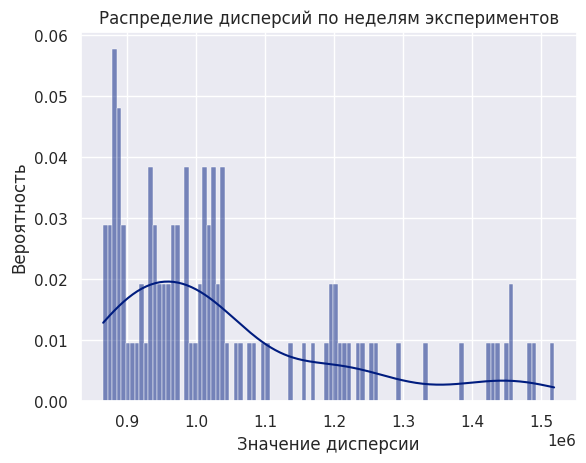

In [68]:
plt.title('Распределие дисперсий по неделям экспериментов')
plt.ylabel('Вероятность')
plt.xlabel('Значение дисперсии')
sns.histplot(var_array, bins=100, kde=True, stat='probability');

In [69]:
effect_size = 100  # Минимальный эффект
var_control = var_test = var_array.mean()  # Дисперсии контрольной и тестовой групп
alpha = 0.05  # Уровень значимости
power = 0.8  # Мощность теста

sample_size = calculate_sample_size_two_groups(effect_size, var_control, var_test, alpha, power)

print('Размер выборки для эксперимента:', sample_size)

Размер выборки для эксперимента: 1651


Проведем синтетические эксперименты, чтобы увидеть распределния p-value, контролируя их с помощью AA-тестов.

In [70]:
num_experiments = 500
dates = list(slice_dict.keys())
aa_test_array = []
ab_test_array = []
control_size = test_size = sample_size
effect_size = 100

for _ in tqdm(range(num_experiments)):
  experiment_date = np.random.choice(dates) # случайно определяем начало эксперимента
  pvalue_aa, pvalue_ab = run_ab_test(slice_dict, experiment_date,
                       control_size, test_size,
                       effect_size, t_test, aa_test=True) # в качестве функции теста используем встроенный t-тест
  aa_test_array.append(pvalue_aa)
  ab_test_array.append(pvalue_ab)

100%|██████████| 500/500 [01:01<00:00,  8.10it/s]


In [71]:
sns.set_theme(style="darkgrid", palette="dark", rc={"font.size": 14})

Видим, что при случайном выборе недели эксперимента p-value синтетических А/А-экспериментов распределено равномерно. Это означает, что p-value позволяет контролировать статистическую значимость результатов. При этом мы достигли необходимой мощности критерия. Однако, она была достигнута при размере выборки, равном 1651 человек. Для некоторых видов нововведений подобный размер выборок невозможно использовать или реализация подобных экспериментов излишне дорого обходится бизнесу.

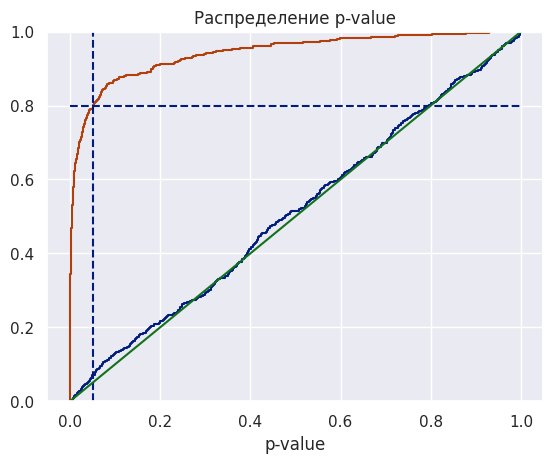

In [73]:
x = np.linspace(0, 1, 100)
sns.ecdfplot(aa_test_array)
sns.ecdfplot(ab_test_array)
plt.vlines(x=0.05, ymin=0, ymax=1, linestyles='--')
plt.hlines(y=0.8, xmin=0, xmax=1, linestyles='--')
plt.plot(x, x)
plt.xlabel('p-value')
plt.ylabel('')
plt.title('Распределение p-value')
plt.show()

Рассмотрим улучшение чувствительности теста с помощью CUPED.

## **2. Применение CUPED: улучшение чувствительности A/B-теста**

В данном разделе мы увидим, что применение техники CUPED (Controlled-experiment Using Pre-Experiment Data) позволяет значительно улучшить чувствительность статистического теста, выигрыш от использования техники мы можем направить на уменьшение необходимой выборки или на уменьшение эффекта, который желаем уловить с помощью тестирования.

### Теоретическое обоснование применения CUPED

**CUPED (Controlled-experiment Using Pre-Experiment Data)** — это метод уменьшения дисперсии в A/B-тестах, позволяющий повысить чувствительность теста. Основная идея CUPED заключается в использовании предтестовых данных для предсказания целевой метрики и последующего исключения объясненной дисперсии, что позволяет уменьшить шум в данных и обнаруживать даже небольшие эффекты.

#### Основная концепция

Допустим, $ Y $ — наша целевая метрика (например, разницы недельных трат клиентов между текущей и предыдущей неделями), которая измеряется в течение эксперимента. CUPED использует ковариат $ X $, которая является значением метрики до начала эксперимента, чтобы улучшить оценку $ Y $. Предполагается, что $ X $ коррелирует с $ Y $, но не зависит от воздействия (то есть, от принадлежности клиента к контрольной или тестовой группе).

Модифицированная метрика $ \tilde{Y} $, применяемая в тесте, вычисляется как:

$$
\tilde{Y} = Y - \theta (X - \bar{X}),
$$

где:
- $ Y $ — значение метрики в экспериментальный период;
- $ X $ — ковариата (метрика до эксперимента);
- $ \bar{X} $ — среднее значение ковариаты $ X $ по всем наблюдениям;
- $ \theta $ — параметр, вычисляемый как:

$$
\theta = \frac{\text{Cov}(Y, X)}{\text{Var}(X)},
$$

где $ \text{Cov}(Y, X) $ — ковариация между $ Y $ и $ X $, а $ \text{Var}(X) $ — дисперсия $ X $.

#### Интуиция метода

1. **Устранение объясненной дисперсии:** Если $ X $ хорошо предсказывает $ Y $, то часть вариации в $ Y $, вызванная $ X $, может быть устранена. Это приводит к уменьшению шума и делает тест более чувствительным.
   
2. **Стабильность метрики:** CUPED преобразует целевую метрику $ Y $, чтобы минимизировать влияние факторов, которые не связаны с воздействием эксперимента.

3. **Увеличение мощности теста:** Уменьшая дисперсию $ Y $, мы уменьшаем стандартную ошибку оценки, что позволяет обнаруживать меньшие эффекты при фиксированном размере выборки.

CUPED позволяет обнаруживать меньшие эффекты при фиксированном размере выборки или уменьшить размер выборки, сохраняя мощность. В качестве ковариаты в наших экспериментах будем использовать значение средних недельных трат за неделю до эксперимента.

In [95]:
def apply_cuped(data, target_column, covariate_column, group_column):
    """
    Применяет метод CUPED для уменьшения дисперсии целевой метрики.

    Аргументы:
        data (pd.DataFrame): Датасет, содержащий данные эксперимента.
        target_column (str): Имя столбца с целевой метрикой (Y).
        covariate_column (str): Имя столбца с ковариатой (X).
        group_column (str): Имя столбца, указывающего принадлежность к группе (контроль/тест).

    Результат:
        pd.DataFrame: Датасет с добавленной колонкой скорректированной метрики (CUPED).
    """
    # Среднее значение ковариаты по всем данным
    X_mean = data[covariate_column].mean()

    # Вычисление параметра θ (theta)
    cov_xy = np.cov(data[target_column], data[covariate_column])[0, 1]
    var_x = np.var(data[covariate_column])
    theta = cov_xy / var_x

    # Корректировка метрики
    data['CUPED_metric'] = data[target_column] - theta * (data[covariate_column] - X_mean)

    return data[['client_id', 'CUPED_metric']].rename({'CUPED_metric': 'sum_purchase'}, axis=1)

In [96]:
slice_dict_for_cuped = {}

for i in range(7, len(dates)):
  prev_date = dates[i-7]
  date = dates[i]
  data_cuped = weekly_slices[prev_date][['client_id', 'sum_purchase']]
  data_cuped = data_cuped.groupby('client_id')['sum_purchase'].sum().reset_index()
  data_cuped = pd.merge(slice_dict[date], data_cuped,
                        on='client_id', how='outer', suffixes=['_cuped', '']).fillna(0)
  slice_dict_for_cuped[date] = apply_cuped(data_cuped, 'sum_purchase',
                                           'sum_purchase_cuped', 'client_id')

Проведем синтетические тесты с размером выборки 1651, который ранее на 5-процентном уровне статистической значимости давал мощность критерия, равную 0.8.

In [99]:
num_experiments = 500
dates = list(slice_dict_for_cuped.keys())
aa_test_cuped = []
ab_test_cuped = []
control_size = test_size = 1651
effect_size = 100

for _ in tqdm(range(num_experiments)):
  experiment_date = np.random.choice(dates) # случайно определяем начало эксперимента
  pvalue_aa, pvalue_ab = run_ab_test(slice_dict_for_cuped, experiment_date,
                       control_size, test_size,
                       effect_size, t_test, aa_test=True) # в качестве функции теста используем встроенный t-тест
  aa_test_cuped.append(pvalue_aa)
  ab_test_cuped.append(pvalue_ab)

100%|██████████| 500/500 [01:05<00:00,  7.61it/s]


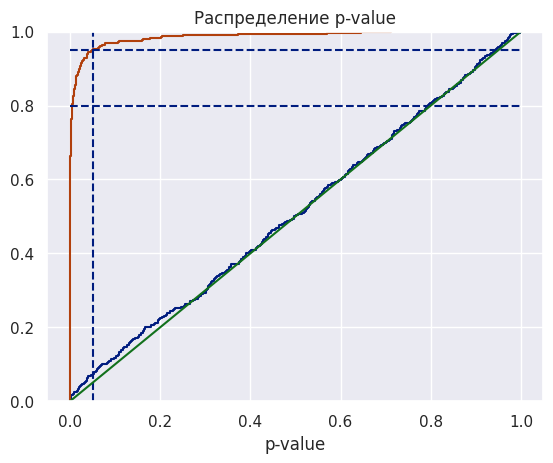

In [102]:
x = np.linspace(0, 1, 100)
sns.ecdfplot(aa_test_cuped)
sns.ecdfplot(ab_test_cuped)
plt.vlines(x=0.05, ymin=0, ymax=1, linestyles='--')
plt.hlines(y=0.8, xmin=0, xmax=1, linestyles='--')
plt.hlines(y=0.95, xmin=0, xmax=1, linestyles='--')
plt.plot(x, x)
plt.xlabel('p-value')
plt.ylabel('')
plt.title('Распределение p-value')
plt.show()

Видим, что при исходном уровне значимости и исходном размере выборки, применение CUPED позволяет увеличить мощность критерия до 0.95. Это может быть излишним, поэтому выигрыш от использования данной техники можем потратить на увеличение чувствительности теста (обнаруживаемого эффекта) или на уменьшение требуемой для тестирования выборки.

Попробуем уменьшить обнаруживаемый эффект.

In [111]:
num_experiments = 300
dates = list(slice_dict_for_cuped.keys())
ab_test_cuped = []
control_size = test_size = 1651
effect_size = 75

for _ in tqdm(range(num_experiments)):
  experiment_date = np.random.choice(dates) # случайно определяем начало эксперимента
  pvalue_ab = run_ab_test(slice_dict_for_cuped, experiment_date,
                       control_size, test_size,
                       effect_size, t_test) # в качестве функции теста используем встроенный t-тест
  ab_test_cuped.append(pvalue_ab)

100%|██████████| 300/300 [00:37<00:00,  7.90it/s]


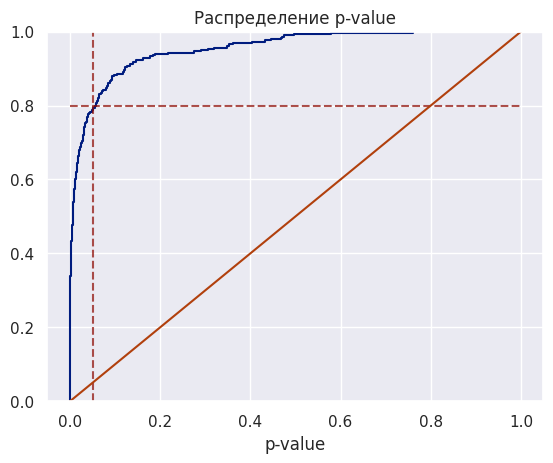

In [112]:
sns.ecdfplot(ab_test_cuped)
plt.vlines(x=0.05, ymin=0, ymax=1, linestyles='--', color='r', alpha=0.7)
plt.hlines(y=0.8, xmin=0, xmax=1, linestyles='--', color='r', alpha=0.7)
plt.plot(x, x)
plt.xlabel('p-value')
plt.ylabel('')
plt.title('Распределение p-value')
plt.show()

Видим, что можно уменьшить обнаруживаемой эффект до 75 руб. при сохранении размера выборки в 1651. Попробуем уменьшить размер выборки

In [122]:
num_experiments = 500
dates = list(slice_dict_for_cuped.keys())
ab_test_cuped = []
control_size = test_size = 900
effect_size = 100

for _ in tqdm(range(num_experiments)):
  experiment_date = np.random.choice(dates) # случайно определяем начало эксперимента
  pvalue_ab = run_ab_test(slice_dict_for_cuped, experiment_date,
                       control_size, test_size,
                       effect_size, t_test) # в качестве функции теста используем встроенный t-тест
  ab_test_cuped.append(pvalue_ab)

100%|██████████| 500/500 [00:57<00:00,  8.76it/s]


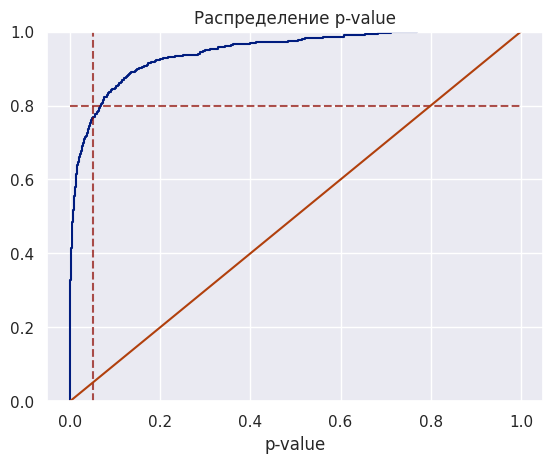

In [123]:
sns.ecdfplot(ab_test_cuped)
plt.vlines(x=0.05, ymin=0, ymax=1, linestyles='--', color='r', alpha=0.7)
plt.hlines(y=0.8, xmin=0, xmax=1, linestyles='--', color='r', alpha=0.7)
plt.plot(x, x)
plt.xlabel('p-value')
plt.ylabel('')
plt.title('Распределение p-value')
plt.show()

Видим, что использование CUPED позволило сократить необходимый размер выборки с 1651 до 900, что довольно позитивно сказывается на бизнес-импликациях различных задач А/В-тестирования.

Мы могли отыскать другие ковариаты, коррелирующие с целевой метрикой, для обеспечения большей чувствительности теста.

Разделы 3, 4 и 5 пока находятся в разработке. Для 3 раздела необходимо подкорректировать реализацию техники линеаризация, чтобы она подходила для тестирования сравнения ARPU, для 4 и 5 есть только синтетические примеры, которые потом будут приложены к задаче на данном датасете.

## **3. Линеаризация: устойчивость в работе с ratio-метриками**

В данном разделе рассматривается использование линеаризации для проведения A/B-тестирования. Основная идея линеаризации заключается в преобразовании ratio-метрики для проведения t-теста Стьюдента и, при необходимости, методов уменьшения дисперсии, например, CUPED.

### Теоретическое обоснование линеаризации метрик

Линеаризация — это метод преобразования ratio-метрик (отношений), таких как средний чек $ \text{ARPU} $, конверсия $ \text{CR} $, или траты на клиента $ \text{ARPPU} $, в аддитивные метрики. Это позволяет использовать стандартные статистические методы, например, t-тест Стьюдента или методы уменьшения дисперсии (например, CUPED), для анализа A/B-тестов. Линеаризация делает анализ более устойчивым и позволяет избежать перекосов, связанных с распределением ratio-метрик.

#### Что такое ratio-метрика?

Ratio-метрика вычисляется как отношение двух величин:

$$
R = \frac{Y}{X},
$$

где:
- $ Y $ — числитель, например, общая сумма покупок;
- $ X $ — знаменатель, например, количество активных клиентов или посещений.

#### Проблемы ratio-метрик

1. **Нелинейность:** Ratio-метрика нелинейна, что делает ее чувствительной к выбросам в $ X $. Это усложняет применение стандартных статистических тестов.
2. **Высокая дисперсия:** Ratio-метрики часто имеют более высокий уровень дисперсии, что снижает мощность тестов.
3. **Сложность корректировки:** Методы уменьшения дисперсии, такие как CUPED, сложны в применении для ratio-метрик.


Линеаризация заключается в разложении ratio-метрики $ R $ в окрестности некоторого базового значения $ X_0 $ по формуле Тейлора. Для малых изменений относительно $ X_0 $, можно записать:

$$
R = \frac{Y}{X} \approx \frac{Y}{X_0} - \frac{\bar{Y}}{X_0^2}(X - X_0),
$$

где $ \bar{Y} $ — среднее значение $ Y $. Это преобразование позволяет заменить $ R $ на линейную аддитивную метрику:

$$
\tilde{R} = Y - \frac{\bar{Y}}{X_0}X.
$$

Преобразование метрики делает её аддитивной, что позволяет применять стандартные статистические тесты, такие как t-тест, а также уменьшает дисперсию метрики, повышая, тем самым, чувствительность теста. Применение данной техники совместимо с CUPED.

Допустим, мы анализируем метрику $ \text{ARPU} $ (средний доход на пользователя):

$$
\text{ARPU} = \frac{\text{Общий доход}}{\text{Количество активных пользователей}}.
$$

С помощью линеаризации можно представить метрику как разницу между общим доходом и откорректированным количеством пользователей. Это позволяет избежать перекосов из-за аномально малых значений знаменателя.

In [141]:
def run_linearized_arpu_test(data, client_column, target_column,
                             control_size, test_size, effect_size, get_no_linearized=False, aa_test=False):
    """
    Проводит A/B-тест на основе линеаризованной метрики.

    Аргументы:
        data (pd.DataFrame): Датасет с данными эксперимента.
        client_column (str): Имя столбца с принадлежностью к группе (контроль/тест).
        target_column (str): Имя столбца с метрикой (линейной или оригинальной).
        control_size (int): Размер контрольной выборки.
        test_size (int): Размер экспериментальной выборки.
        effect_size (float): Размер ожидаемого эффекта.
        get_no_linearized (bool): Флаг, устанавливающий, будет ли проводиться тест без линеаризации.
        aa_test (bool): Флаг, устанавливающий, будет ли проводиться A/A-тест.

    Результат:
        float: p-value теста.
    """

    unique_clients = data['client_id'].unique() # Получаем список клиентов

    np.random.shuffle(unique_clients)
    control_clients = unique_clients[:control_size]
    test_clients = unique_clients[control_size:control_size + test_size]

    control = data[data[client_column].isin(control_clients)][target_column]
    test = data[data[client_column].isin(test_clients)][target_column]
    linear_mean = control.mean()
    control = control - linear_mean
    test = test - linear_mean + effect_size

    _, p_value = ttest_ind(control, test, equal_var=False)
    return p_value

In [159]:
def run_linearized_arpu_test(data, client_column, target_column,
                             control_size, test_size, effect_size):
    """
    Проводит A/B-тест или A/A-тест на основе линеаризованной или оригинальной метрики.

    Аргументы:
        data (pd.DataFrame): Датасет с данными эксперимента.
        client_column (str): Имя столбца с принадлежностью к группе (контроль/тест).
        target_column (str): Имя столбца с метрикой (линейной или оригинальной).
        control_size (int): Размер контрольной выборки.
        test_size (int): Размер экспериментальной выборки.
        effect_size (float): Размер ожидаемого эффекта.

    Результат:
        dict: Содержит p-value для разных тестов.
    """
    # Получение списка уникальных клиентов
    unique_clients = data[client_column].unique()
    np.random.shuffle(unique_clients)

    # Разделение клиентов на контрольную и тестовую группы
    control_clients = unique_clients[:control_size]
    test_clients = unique_clients[control_size:control_size + test_size]

    # Формирование выборок
    control = data[data[client_column].isin(control_clients)][target_column]
    test = data[data[client_column].isin(test_clients)][target_column]

    results = {}

    # Оригинальная метрика

    test_with_effect = test + effect_size
    _, p_value_ab_original = ttest_ind(control, test_with_effect, equal_var=False)
    results['p_value_original'] = p_value_ab_original


    # Линеаризация
    linear_mean = control.mean()
    control_linear = control - linear_mean
    test_linear = test - linear_mean + effect_size
    _, p_value_ab_linearized = ttest_ind(control_linear, test_linear, equal_var=False)

    results['p_value_linearized'] = p_value_ab_linearized

    return results

In [131]:
slice_dict_linearization = {}

for i in range(7, len(dates)):
  date = dates[i]
  data_linearization = weekly_slices[date][['client_id', 'sum_purchase']]
  slice_dict_linearization[date] = data_linearization.groupby('client_id')['sum_purchase'].sum().reset_index()

In [139]:
num_experiments = 100
dates = list(slice_dict_linearization.keys())
ab_test_linearization = []
control_size = test_size = 1561
effect_size = 100

for _ in tqdm(range(num_experiments)):
  experiment_date = np.random.choice(dates) # случайно определяем начало эксперимента
  data = slice_dict_linearization[experiment_date]
  pvalue_ab = run_linearized_arpu_test(data, 'client_id',
                                       'sum_purchase', control_size,
                                       test_size, effect_size)
  ab_test_linearization.append(pvalue_ab)

100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


In [160]:
num_experiments = 100
dates = list(slice_dict_linearization.keys())
aa_test_linearization = []
aa_test_original = []
ab_test_linearization = []
ab_test_original = []
control_size = test_size = 1561
effect_size_aa = 0  # Для A/A-теста эффект равен нулю
effect_size_ab = 100  # Устанавливаем эффект для A/B-теста

for _ in tqdm(range(num_experiments)):
    # Случайно определяем начало эксперимента
    experiment_date = np.random.choice(dates)
    data = slice_dict_linearization[experiment_date]
    results_aa = run_linearized_arpu_test(
        data,
        client_column='client_id',
        target_column='sum_purchase',
        control_size=control_size,
        test_size=test_size,
        effect_size=effect_size_aa
    )
    results_ab = run_linearized_arpu_test(
        data,
        client_column='client_id',
        target_column='sum_purchase',
        control_size=control_size,
        test_size=test_size,
        effect_size=effect_size
    )
    aa_test_original.append(results_aa['p_value_original'])
    aa_test_linearization.append(results_aa['p_value_linearized'])
    ab_test_original.append(results_ab['p_value_original'])
    ab_test_linearization.append(results_ab['p_value_linearized'])

100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


In [164]:
aa_test_original[0] == aa_test_linearization[0]

False

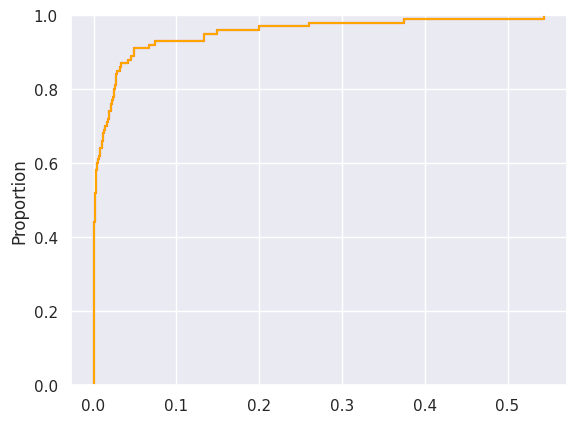

In [166]:
sns.ecdfplot(ab_test_original, label="A/B Test (Original)", color='red')
sns.ecdfplot(ab_test_linearization, label="A/B Test (Linearized)", color='orange');

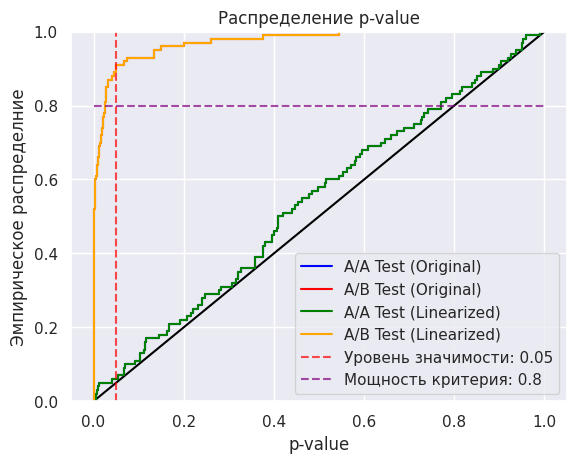

In [161]:
x = np.linspace(0, 1, 100)
plt.plot(x, x, color='black')
sns.ecdfplot(aa_test_original, label="A/A Test (Original)", color='blue')
sns.ecdfplot(ab_test_original, label="A/B Test (Original)", color='red')
sns.ecdfplot(aa_test_linearization, label="A/A Test (Linearized)", color='green')
sns.ecdfplot(ab_test_linearization, label="A/B Test (Linearized)", color='orange')
plt.vlines(x=0.05, ymin=0, ymax=1, linestyles='--', color='red', alpha=0.7, label="Уровень значимости: 0.05")
plt.hlines(y=0.8, xmin=0, xmax=1, linestyles='--', color='purple', alpha=0.7, label="Мощность критерия: 0.8")
plt.xlabel('p-value')
plt.ylabel('Эмпирическое распределние')
plt.title('Распределение p-value')
plt.legend()
plt.show()

## **4. Множественное тестирование: контроль ошибок 1-го рода**

В этом разделе рассматривается проблема множественного тестирования, когда проводятся несколько A/B-тестов одновременно. Для снижения вероятности ложных положительных результатов применяются методы коррекции p-значений, такие как Бонферрони, Холм-Бонферрони и FDR (False Discovery Rate). Будет показано, как использование этих методов позволяет улучшить достоверность выводов.


### Теоретическая выкладка для множественного тестирования

Множественное тестирование возникает, когда одновременно проводится несколько гипотез. Например, A/B-тесты могут быть проведены для нескольких метрик, продуктов или сегментов пользователей. При увеличении числа тестов возрастает вероятность получения ложноположительных результатов (ошибка первого рода).  

Чтобы снизить вероятность ложных открытий, используются методы корректировки, которые контролируют уровень значимости $ \alpha $:  

1. **Поправка Бонферрони**  
   Делит общий уровень значимости $ \alpha $ на число тестов $ m $. Например, если $ \alpha = 0.05 $ и $ m = 10 $, то каждое отдельное тестирование проводится на уровне $ \alpha/m = 0.005 $.

2. **FDR (False Discovery Rate)**  
   Подход Бенджамини-Хохберга контролирует долю ложноположительных гипотез среди всех отвергнутых. Этот метод менее строгий, чем Бонферрони, и чаще используется в анализе больших наборов данных.

In [171]:
# Генерация p-value из 20 тестов
np.random.seed(42)
p_values = np.random.uniform(0.01, 0.10, 20)

# Создание DataFrame
tests_df = pd.DataFrame({
    'Test': [f'Test_{i+1}' for i in range(len(p_values))],
    'p_value': p_values
})

# Поправка Бонферрони
tests_df['Bonferroni'] = multipletests(tests_df['p_value'], method='bonferroni')[1]
# Поправка Бенджамини-Хохберга (FDR)
tests_df['FDR'] = multipletests(tests_df['p_value'], method='fdr_bh')[1]

In [172]:
# Добавляем столбец с результатами (True = отвергаем нулевую гипотезу)
alpha = 0.05
tests_df['Reject_H0_Bonferroni'] = tests_df['Bonferroni'] < alpha
tests_df['Reject_H0_FDR'] = tests_df['FDR'] < alpha

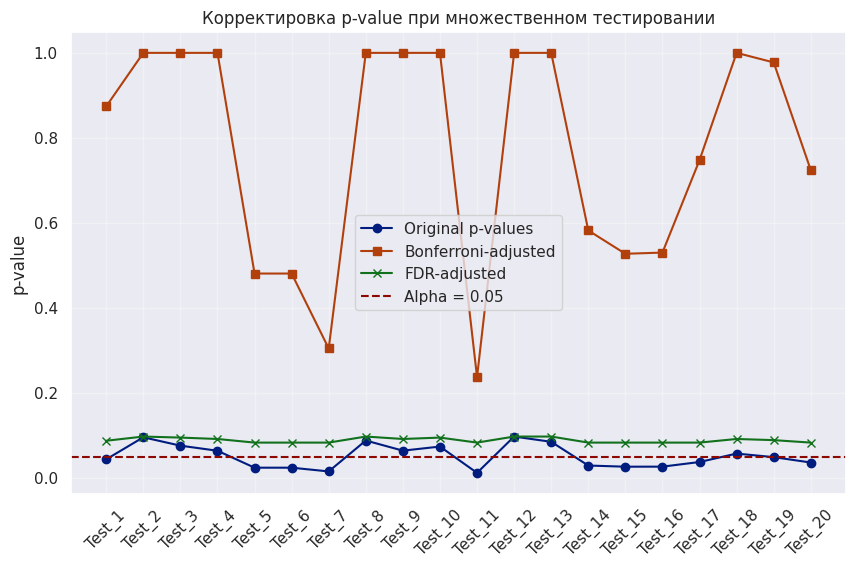

In [173]:
plt.figure(figsize=(10, 6))
plt.plot(tests_df['p_value'], 'o-', label='Original p-values')
plt.plot(tests_df['Bonferroni'], 's-', label='Bonferroni-adjusted')
plt.plot(tests_df['FDR'], 'x-', label='FDR-adjusted')
plt.axhline(y=alpha, color='r', linestyle='--', label=f'Alpha = {alpha}')
plt.xticks(ticks=range(len(p_values)), labels=tests_df['Test'], rotation=45)
plt.ylabel('p-value')
plt.title('Корректировка p-value при множественном тестировании')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## **5. Байесовский подход: гибкость и информативность анализа**

Байесовский подход предлагает альтернативу классическим методам статистического тестирования. Вместо расчёта p-значений мы оцениваем вероятности гипотез на основе априорной и апостериорной информации. Этот подход особенно полезен для интерпретации результатов и принятия решений в условиях неопределённости. В данном разделе демонстрируется использование Байесовского подхода для оценки эффекта изменений.

Байесовские методы применяются для анализа A/B-тестов, чтобы вычислить вероятность гипотез на основе наблюдаемых данных. В отличие от классического подхода (например, t-теста), который оперирует p-value и проверяет нулевую гипотезу, байесовский подход позволяет ответить на более интуитивные вопросы:

1. **Какова вероятность того, что тестовая группа лучше контрольной?**
2. **Какова вероятность превышения эффекта определённого размера?**

Базовая идея:
1. Определяем **априорное распределение** параметра (например, среднего или пропорции).  
   - Это наше предположение до эксперимента.
2. Используем данные, чтобы обновить распределение, вычислив **апостериорное распределение**.  
   - Это наше мнение после наблюдений.
3. На основе апостериорного распределения оцениваем интересующие нас метрики.

Типичные задачи:
- Для бинарных данных (конверсий): используем распределения Бета-Бернулли.  
- Для непрерывных данных (ARPU, выручка): нормальные распределения или гамма-экспоненциальные.

### Байесовское сравнение средних (непрерывные данные)

#### Пусть:
- $ X_i \sim \mathcal{N}(\mu_X, \sigma_X^2) $ — контрольная группа.
- $ Y_i \sim \mathcal{N}(\mu_Y, \sigma_Y^2) $ — тестовая группа.

Мы хотим оценить:
1. $ P(\mu_Y > \mu_X) $ — вероятность, что тестовая группа лучше.
2. $ P(\mu_Y - \mu_X > \Delta) $ — вероятность, что эффект превышает порог $ \Delta $.

Используем байесовский вывод:
- Априорное распределение: $ \mu_X, \mu_Y \sim \mathcal{N}(\mu_0, \sigma_0^2) $.
- После обновления на основе данных: $ \mu_X, \mu_Y $ следуют нормальному распределению с параметрами, вычисленными из данных.

In [174]:
# Функция для байесовского теста
def bayesian_ab_test(control_data, test_data, delta=0):
    """
    Проводит байесовское сравнение двух групп с непрерывными данными.

    Аргументы:
        control_data (array): Данные контрольной группы.
        test_data (array): Данные тестовой группы.
        delta (float): Минимальный размер эффекта, который нужно оценить.

    Возвращает:
        dict: Вероятности P(mu_Y > mu_X) и P(mu_Y - mu_X > delta).
    """
    # Считаем статистики
    n_control = len(control_data)
    n_test = len(test_data)
    mean_control, var_control = np.mean(control_data), np.var(control_data, ddof=1)
    mean_test, var_test = np.mean(test_data), np.var(test_data, ddof=1)

    # Апостериорное распределение разницы средних
    diff_mean = mean_test - mean_control
    diff_std = np.sqrt(var_control / n_control + var_test / n_test)

    # Вычисление вероятностей
    p_mu_y_greater_mu_x = 1 - norm.cdf(0, loc=diff_mean, scale=diff_std)
    p_effect_greater_delta = 1 - norm.cdf(delta, loc=diff_mean, scale=diff_std)

    return {
        'P(mu_Y > mu_X)': p_mu_y_greater_mu_x,
        'P(mu_Y - mu_X > delta)': p_effect_greater_delta
    }

# Пример данных
np.random.seed(42)
control_data = np.random.normal(100, 15, 500)  # Среднее = 100, стандартное отклонение = 15
test_data = np.random.normal(105, 15, 500)     # Среднее = 105, стандартное отклонение = 15

# Байесовский анализ
results = bayesian_ab_test(control_data, test_data, delta=5)

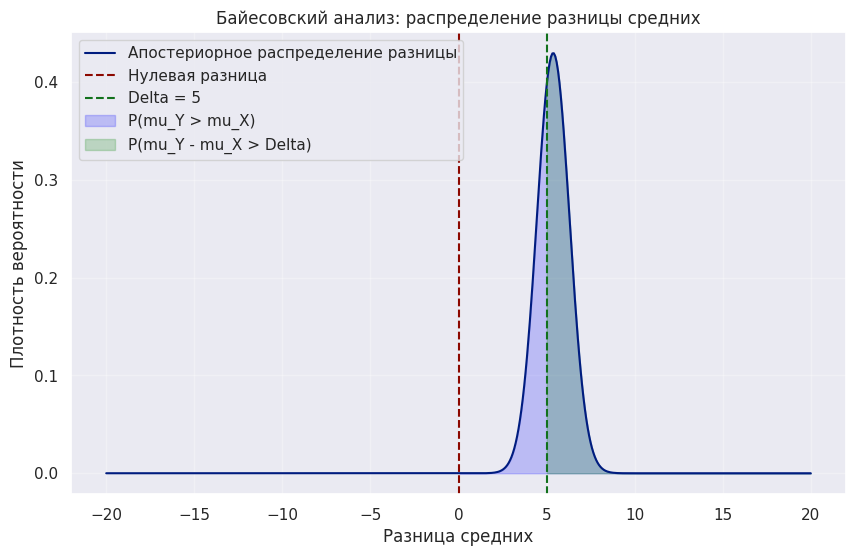

In [175]:
# Визуализация апостериорного распределения
x = np.linspace(-20, 20, 500)
posterior = norm(loc=np.mean(test_data) - np.mean(control_data),
                 scale=np.sqrt(np.var(control_data) / len(control_data) +
                               np.var(test_data) / len(test_data)))

plt.figure(figsize=(10, 6))
plt.plot(x, posterior.pdf(x), label='Апостериорное распределение разницы')
plt.axvline(0, color='r', linestyle='--', label='Нулевая разница')
plt.axvline(5, color='g', linestyle='--', label='Delta = 5')
plt.fill_between(x, 0, posterior.pdf(x), where=(x > 0), color='blue', alpha=0.2, label='P(mu_Y > mu_X)')
plt.fill_between(x, 0, posterior.pdf(x), where=(x > 5), color='green', alpha=0.2, label='P(mu_Y - mu_X > Delta)')
plt.title('Байесовский анализ: распределение разницы средних')
plt.xlabel('Разница средних')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Интерпретация:
- **$P(mu_Y > mu_X)$**: Вероятность, что тестовая группа лучше контрольной.  
- **$P(mu_Y - mu_X > Delta)$**: Вероятность, что прирост тестовой группы превышает определённый порог $ \Delta $.  

Байесовский подход позволяет не только тестировать гипотезы, но и оценивать степень уверенности в различиях между группами.